# Libraries

In [1]:
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score,
    KFold
)
from optuna.visualization import (
    plot_optimization_history, 
    plot_param_importances, 
    plot_slice
)
from sklearn import set_config
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from tqdm import tqdm
from openfe import (
    OpenFE, 
    transform, 
    tree_to_formula, 
    ForwardFeatureSelector, 
    TwoStageFeatureSelector
)
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
import optuna
import shap
import warnings
import gc

# Configuration

In [2]:
# Global configurations for sklearn:
set_config(transform_output="pandas")

# Global configurations for pandas:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)
pd.set_option("display.precision", 3)
pd.set_option("display.max_colwidth", None)

# Suppress warnings
warnings.filterwarnings("ignore")

In [3]:
SEED = 42
TRAIN_SIZE = 100000
DATA_DIR = 'data/'

# Functions

In [4]:
def memory_optimization(train_data: pd.DataFrame) -> pd.DataFrame:
    """ Reduce memory usage of dataframe by modifying type of each column.

    Argument:
    train_data (pd.DataFrame): The DataFrame to be optimized.
    """
    base_memory = train_data.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {base_memory:.2f} MB')

    for column in train_data.columns:
        column_type = train_data[column].dtype

        if column_type == 'bool':
            continue

        if column_type != 'object':
            column_value_min = train_data[column].min()
            column_value_max = train_data[column].max()
            if str(column_type)[:3] == 'int':
                if column_value_min > np.iinfo(np.int8).min and column_value_max < np.iinfo(np.int8).max:
                    train_data[column] = train_data[column].astype(np.int8)
                elif column_value_min > np.iinfo(np.int16).min and column_value_max < np.iinfo(np.int16).max:
                    train_data[column] = train_data[column].astype(np.int16)
                elif column_value_min > np.iinfo(np.int32).min and column_value_max < np.iinfo(np.int32).max:
                    train_data[column] = train_data[column].astype(np.int32)
                elif column_value_min > np.iinfo(np.int64).min and column_value_max < np.iinfo(np.int64).max:
                    train_data[column] = train_data[column].astype(np.int64)  
            else:
                if column_value_min > np.finfo(np.float16).min and column_value_max < np.finfo(np.float16).max:
                    train_data[column] = train_data[column].astype(np.float16)
                elif column_value_min > np.finfo(np.float32).min and column_value_max < np.finfo(np.float32).max:
                    train_data[column] = train_data[column].astype(np.float32)
                else:
                    train_data[column] = train_data[column].astype(np.float64)
        else:
            train_data[column] = train_data[column].astype('category')

    optimized_memory = train_data.memory_usage().sum() / 1024**2
    optimized_percentage = 100 * (base_memory - optimized_memory) / base_memory

    print(f'Memory usage after optimization is: {optimized_memory:.2f} MB')
    print(f'Decreased by {optimized_percentage:.1f}%')

    return train_data

# Read data

In [5]:
# Original data
org_data = pd.read_csv(DATA_DIR + 'data.csv', delimiter=';')

# Competition data
org_train = pd.read_csv(DATA_DIR + 'train.csv')

In [6]:
# Rename to merge
org_data.rename(columns={'Daytime/evening attendance\t': 'Daytime/evening attendance'}, inplace=True)

# Enrich dataset
org_train.drop('id', axis=1, inplace=True)
df = pd.concat([org_train, org_data])
df.reset_index(drop=True, inplace=True)

df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,1,1,9238,1,1,126.0,1,1,19,5,5,122.6,0,0,0,1,0,1,18,0,0,6,6,6,14.500,0,0,6,7,6,12.429,0,11.1,0.6,2.02,Graduate
1,1,17,1,9238,1,1,125.0,1,19,19,9,9,119.8,1,0,0,1,0,0,18,0,0,6,8,4,11.600,0,0,6,9,0,0.000,0,11.1,0.6,2.02,Dropout
2,1,17,2,9254,1,1,137.0,1,3,19,2,3,144.7,0,0,0,1,1,0,18,0,0,6,0,0,0.000,0,0,6,0,0,0.000,0,16.2,0.3,-0.92,Dropout
3,1,1,3,9500,1,1,131.0,1,19,3,3,2,126.1,1,0,0,1,0,1,18,0,0,7,9,7,12.591,0,0,8,11,7,12.820,0,11.1,0.6,2.02,Enrolled
4,1,1,2,9500,1,1,132.0,1,19,37,4,9,120.1,1,0,0,1,0,0,18,0,0,7,12,6,12.933,0,0,7,12,6,12.933,0,7.6,2.6,0.32,Graduate


In [7]:
%%time
# Optimize memory usage
df = memory_optimization(df)

Memory usage of dataframe is 22.85 MB
Memory usage after optimization is: 3.63 MB
Decreased by 84.1%
CPU times: user 10.5 ms, sys: 1.18 ms, total: 11.7 ms
Wall time: 11 ms


# EDA

In [8]:
print(f'Before concat: {org_train.shape}, {org_data.shape}\n')
print(f'After concat: {df.shape}')

del org_train, org_data
gc.collect()

Before concat: (76518, 37), (4424, 37)

After concat: (80942, 37)


0

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80942 entries, 0 to 80941
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   Marital status                                  80942 non-null  int8    
 1   Application mode                                80942 non-null  int8    
 2   Application order                               80942 non-null  int8    
 3   Course                                          80942 non-null  int16   
 4   Daytime/evening attendance                      80942 non-null  int8    
 5   Previous qualification                          80942 non-null  int8    
 6   Previous qualification (grade)                  80942 non-null  float16 
 7   Nacionality                                     80942 non-null  int8    
 8   Mother's qualification                          80942 non-null  int8    
 9   Father's qualification      

## Target

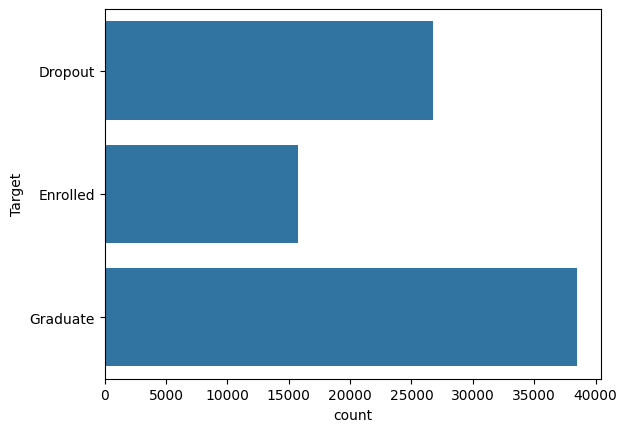

In [10]:
sns.countplot(df.Target)
plt.show()

# Pre-processing

# Feature engineering

# Metric

# Modeling

# Evaluation

# Prediction & Submission

# Autogluon

In [11]:
%%time
#0.85831 
label = "Target"
predictor = TabularPredictor(label=label, problem_type='multiclass', verbosity=1).fit(df, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20240605_095727"


CPU times: user 4min 44s, sys: 11.5 s, total: 4min 56s
Wall time: 1h 2s


In [12]:
test = pd.read_csv(DATA_DIR + 'test.csv')
predictions = predictor.predict(test.drop('id', axis=1))

sub = pd.read_csv(DATA_DIR + 'sample_submission.csv')
sub[label] = predictions
sub.to_csv('submission.csv', index=False)

# Reference